# Self-Driving Car Engineer Nanodegree

## Project #2: **Advanced Lane Finding**


### Notebook Configuration

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = -1;

## Import Packages

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import pathlib as pl
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

## Camera Calibration

In [3]:
# Directory containing the chessboard images for camera calibration
calibration_dir = "camera_cal"
# Number of chessboard columns
chessboard_nx = 9
# Number of chessboard rows
chessboard_ny = 6

# Memoized camera calibrations (indexed by image shape)
camera_calibration = {}

def calibrate_camera(shape):
    """
    Given a picture shape, perform a camera calibration using the available chessboard images,
    and memoize the result.
    """
    
    # Prepare memoization cache
    global camera_calibration
    if shape in camera_calibration:
        return camera_calibration[shape];

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((chessboard_ny*chessboard_nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:chessboard_nx,0:chessboard_ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # plt.figure()
    # fig, axs = plt.subplots(2, 3, figsize=(10,5), tight_layout=True)
    # ax_iter = iter(axs.flatten())

    # Step through the list and search for chessboard corners
    for file in sorted(pl.Path(calibration_dir).glob("cal*.jpg")):
        img = cv2.imread(str(file))
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (chessboard_nx,chessboard_ny),None)

        if ret == False:
            continue

        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        # img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #
        # ax = next(ax_iter, None)
        # if ax != None:
        #     ax.imshow(img)

    # Perform calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)

    # Cache the result and return
    camera_calibration[shape] = (mtx, dist)
    return camera_calibration[shape]


def undistort_image(img):
    """
    Undistort an image.
    """
    
    # Retrieve the appropriate calibration data for the given image shape
    cal = calibrate_camera(img.shape[1::-1]);
    
    # Undistort and return
    return cv2.undistort(img, cal[0], cal[1], None, cal[0])

## Verify Camera Calibration

True

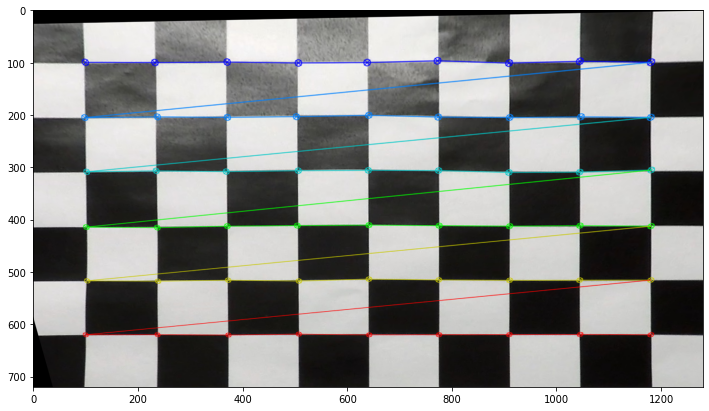

In [14]:
def undistort_warp_chessboard(img):
    """
    Verify the camera calibration by performing a chessboard detection and perspective tranform
    on a supposedly undistorted image.
    
    The resulting image should picture a perfectly undistorted and straight chessboard pattern.
    """
    w, h = img.shape[1::-1]

    img_undist = undistort_image(img)

    ret, corners = cv2.findChessboardCorners(img_undist, (chessboard_nx,chessboard_ny), None)
    if ret:
        cv2.drawChessboardCorners(img_undist, (chessboard_nx,chessboard_ny), corners, True)
        src = np.array([corners[0], corners[chessboard_nx-1], corners[-1], corners[-chessboard_nx]], dtype=np.float32);
        dst = np.array([[100,100], [w-100,100], [w-100,h-100], [100,h-100]], dtype=np.float32);
        M = cv2.getPerspectiveTransform(src, dst)
        img_undist = cv2.warpPerspective(img_undist, M, (w, h), flags=cv2.INTER_CUBIC)

    return img_undist


# Test camera calibration using one of the chessboard images

img = cv2.imread('camera_cal/calibration3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = undistort_warp_chessboard(img)

plt.figure()
plt.imshow(img)

img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite('examples/undistorted_calibration.jpg', img)


## Gradient and Color Thresholds

In [5]:
def thresholds(img, s_thresh=(110, 255), sr_thresh=(150, 255), r_thresh=(240, 255),
               sx_thresh=(30, 100), ksize=5):
    """
    Convert an image to a binary representation, applying x-gradient and S/R channel thresholds.
    """

    # extract R channel from RGB image
    r_channel = img[:,:,0]
    
    # convert to HLS color space and extract channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=ksize) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sobelx_binary = np.zeros_like(scaled_sobelx)
    sobelx_binary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1

    # Threshold color channels S with the inclusion of R
    s_binary = np.zeros_like(s_channel)
    s_binary[
        (s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) & \
        (r_channel >= sr_thresh[0]) & (r_channel <= sr_thresh[1])   ] = 1

    # Threshold color channels R only
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1

    # Prepare the result combined binary for later processing
    combined_binary = np.zeros_like(sobelx_binary)
    combined_binary[(sobelx_binary == 1) | (r_binary == 1) | (s_binary == 1)] = 1
    
    # Stack 3 binaries for visualization
    color_binary = np.dstack((r_binary, sobelx_binary, s_binary)) * 255
    
    return combined_binary, color_binary

## Perspective Transform

In [6]:
def warp_src(img_size):
    """
    Returns trapezoid coordinates as source for the perspective transform.
    """
    return np.float32([
        [img_size[0] / 2 - 57, img_size[1] * 0.5 + 100],
        [img_size[0] / 6 - 7, img_size[1]],
        [img_size[0] * 5 / 6 + 40, img_size[1]],
        [img_size[0] / 2 + 57, img_size[1] * 0.5 + 100]
    ])


def warp_dst(img_size):
    """
    Returns a rectangle as destination geometry for the perspective transform.
    """
    return np.float32([
        [(img_size[0] * 0.25), 0],
        [(img_size[0] * 0.25), img_size[1]],
        [(img_size[0] * 0.75), img_size[1]],
        [(img_size[0] * 0.75), 0]
    ])


# Cache for perspective transform matrices (indexed by image shape)
perspective_matrix = {}

def warp_image(img, inverse=False):
    """
    Perform warping and unwarping (inverse=True) of images.
    """

    img_size = img.shape[1::-1]

    src = warp_src(img_size)
    dst = warp_dst(img_size)

    # Compute and cache matrices for perspective transformation in both directions
    global perspective_matrix
    if img_size not in perspective_matrix:
        perspective_matrix[img_size] = (
            cv2.getPerspectiveTransform(src, dst),
            cv2.getPerspectiveTransform(dst, src)
        )
    
    # Apply perspective transform
    return cv2.warpPerspective(img, perspective_matrix[img_size][int(inverse)], img_size, flags=cv2.INTER_NEAREST)


## Helper Functions

In [7]:
class Line():
    """
    Class to receive the characteristics of each line detection
    """
    def __init__(self):
        # Number of previously failed detections
        self.failed_detections = 0
        # Last fit successful
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        # Average x values of the fitted line over the last n iterations
        self.bestx = None
        # Polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # Polynomial coefficients of the last n fits
        self.current_fit = []
        # Radius of curvature of the line in some units based on .best_fit
        self.radius_of_curvature = None
        # Distance in meters of vehicle center from the line based on .bestx
        self.line_base_pos = None
        # Difference in fit coefficients between last and new fits
        self.diffs = None
        # x values for detected line pixels in last fit
        self.allx = None
        # y values for detected line pixels in last fit
        self.ally = None
        

def fy(y, poly_coeffs):
    """
    Calculate the function value of y given a set of polynomial coefficients.
    """
    f = np.poly1d(poly_coeffs)
    return f(y)


def fy_d1(y, poly_coeffs):
    """
    Calculate the first derivative of y given a set of polynomial coefficients.
    """
    f2 = np.poly1d(poly_coeffs).deriv()
    return f2(y)

def fy_d2(y, poly_coeffs):
    """
    Calculate the second derivative of y given a set of polynomial coefficients.
    """
    f2 = np.poly1d(poly_coeffs).deriv().deriv()
    return f2(y)


def plot_fits(img, poly_fits):
    """
    Plot each provided fit polynomial onto an image.
    """
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])

    # Calc both polynomials using plot and
    # and plot the polynomial lines onto the image
    for fit in poly_fits:
        if len(fit) > 1:
            fitx = fy(ploty, fit)
            draw_pts = (np.asarray([fitx, ploty]).T).astype(np.int32)
            cv2.polylines(img, [draw_pts], False, (255,255,0), 3)

    return img


def fit_poly(leftx, lefty, rightx, righty, deg=2):
    """
    Fit a third order polynomial to each group of pixels specified by
    (leftx, lefty) and (rightx, righty) using np.polyfit().
    """
    
    if len(leftx) < 3:
        left_fit = np.array([False], dtype=bool)
    else:
        left_fit = np.polyfit(lefty, leftx, deg)
        
    if len(rightx) < 3:
        right_fit = np.array([False], dtype=bool)
    else:
        right_fit = np.polyfit(righty, rightx, deg)
        
    return left_fit, right_fit


def radius_curvature(coeffs, y):
    """
    Calculate the curvature radius of a polynomial at position y.
    """
    return ( (1.0+(2.0*coeffs[0]*y+coeffs[1])**2.0)**(3.0/2.0) ) / ( 2.0 * abs(coeffs[0]) )


def calculate_stats(img, line):
    """
    Calculate the curve radius and line base position of a line in meters.
    """
    
    # Define conversions in x and y from pixels space to meters
    y_m_per_pix = 30.0 / 720
    x_m_per_pix = 3.7 / 700

    fit = line.best_fit
    
    img_w = img.shape[1]
    img_h = img.shape[0]
    
    # Generate points from fit polynomial
    ploty = np.linspace(0, img_h-1, img_h)
    fitx = fy(ploty, fit)
    
    # Fit new polynomials to x, y in world space
    fit_cr  = np.polyfit(ploty * y_m_per_pix, fitx * x_m_per_pix, 2)
    
    # Calculate radius of curve
    line.radius_of_curvature = radius_curvature(fit_cr, x_m_per_pix * img_w)
    
    # Use intercept x to calculate the line distance from vehicle center
    line.line_base_pos = x_m_per_pix * ((img_w / 2.0) - fy(img_h, fit))
    
    return line
       

def draw_lane_unwarped(img, lines):
    """
    Given the (undistorted) source image, draw the results of the fit and some stats
    converted to from pixels to meters.
    """
    
    left_fit = lines[0].best_fit
    leftx = lines[0].allx
    lefty = lines[0].ally
    
    right_fit = lines[1].best_fit
    rightx = lines[1].allx
    righty = lines[1].ally
    
    # Calulate mean curvature of left and right line, as well as the lane deviation
    curvature = (lines[0].radius_of_curvature + lines[1].radius_of_curvature) * 0.5
    lane_deviation = (lines[0].line_base_pos + lines[1].line_base_pos) * 0.5
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = fy(ploty, left_fit)
    right_fitx = fy(ploty, right_fit)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros(img.shape[0:2], np.uint8)
    area_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    lines_warp_left = np.copy(warp_zero)
    lines_warp_right = np.copy(warp_zero)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(area_warp, np.int_([pts]), (0, 255, 0))
    
    # Mark selected pixels
    lines_warp_left[lefty, leftx] = 1
    lines_warp_right[righty, rightx] = 1

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    area_unwarp = warp_image(area_warp, True)
    lines_unwarp_left = warp_image(lines_warp_left, True)
    lines_unwarp_right = warp_image(lines_warp_right, True)
    
    # Combine the result with the original image

    img_out = cv2.addWeighted(img, 1, area_unwarp, 0.3, 0)
#     img_out = cv2.addWeighted(img_out, 1, lines_unwarp, 0.7, 0)
    
    lines_unwarp_left[::2] = 0
    lines_unwarp_right[::2] = 0
    img_out[np.nonzero(lines_unwarp_left)] = (255, 0, 0)
    img_out[np.nonzero(lines_unwarp_right)] = (0, 0, 255)
    
    # Write statistics of the fit onto the image
    curvature_text = "Radius of curvature = {:.1f} m".format(curvature)
    cv2.putText(img_out, curvature_text, (30, 60), cv2.FONT_HERSHEY_DUPLEX, 1, (255,255,255), 2)
    deviation_text = "Vehicle offset from lane center = {:.2f} m".format(lane_deviation) 
    cv2.putText(img_out, deviation_text, (30, 90), cv2.FONT_HERSHEY_DUPLEX, 1, (255,255,255), 2) 
    
    return img_out

## Fit functions

In [8]:
def fit_lane_by_windows(binary_warped, lines):
    """
    Fit lane lines to a binary warped image using the sliding window technique.
    """

    # Choose the number of sliding windows
    nwindows = 12
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 80
    
    # Image dimensions
    img_w = binary_warped.shape[1]
    img_h = binary_warped.shape[0]
    
    # Take a histogram of the bottom half of the image,
    # assign larger weights the closer pixels are to the bottom end
    histogram = 4 * np.sum(binary_warped[-img_h//8:,:], axis=0) \
              + 2 * np.sum(binary_warped[-img_h//4:-img_h//8,:], axis=0) \
              +     np.sum(binary_warped[-img_h//2:-img_h//4,:], axis=0)

    # Create an output image to draw on and visualize the result
    img_out = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]*0.5)
    leftx_base  = np.argmax(histogram[:midpoint])
    rightx_base = midpoint + np.argmax(histogram[midpoint:])

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img_h//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    leftx_diff = 0
    rightx_diff = 0
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    img_rectangles = np.zeros_like(img_out)
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img_h - (window+1)*window_height
        win_y_high = img_h - window*window_height
        # ind the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(img_rectangles,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(img_rectangles,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)

        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = (
            (nonzerox <= img_w // 2) &
            (win_xleft_low <= nonzerox) & (nonzerox < win_xleft_high) & (win_y_low <= nonzeroy) & (nonzeroy < win_y_high)
        ).nonzero()[0]
        
        good_right_inds = (
            (nonzerox >= img_w // 2) &
            (win_xright_low <= nonzerox) & (nonzerox < win_xright_high) & (win_y_low <= nonzeroy) & (nonzeroy < win_y_high)
        ).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If more than minpix pixels are found in the current window, recenter next window
        # but add half of the last window offset to not "lag" behind.
        # Otherwise, keep moving the window by the last confirmed offset.
        if len(good_left_inds) > minpix:
            leftx_new = np.int(np.mean(nonzerox[good_left_inds])) + leftx_diff // 2
            leftx_diff = leftx_new - leftx_current
            leftx_current = leftx_new
        else:
            leftx_current += leftx_diff
            
        if len(good_right_inds) > minpix:
            rightx_new = np.int(np.mean(nonzerox[good_right_inds])) + rightx_diff // 2
            rightx_diff = rightx_new - rightx_current
            rightx_current = rightx_new
        else:
            rightx_current += rightx_diff
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Draw windows and selected pixels onto visualization image
    img_out[lefty, leftx] = [255, 0, 0]
    img_out[righty, rightx] = [0, 0, 255]
    img_out = cv2.addWeighted(img_out, 1.0, img_rectangles, 0.7, 1)
        
    # Now fit the polynomial
    left_fit, right_fit = fit_poly(leftx, lefty, rightx, righty)
    
    # Draw the fitted polynomials onto the result image
    plot_fits(img_out, [left_fit, right_fit])
    
    # Prepare return values
    lines[0].current_fit.append(left_fit)
    lines[0].allx = leftx
    lines[0].ally = lefty
    
    lines[1].current_fit.append(right_fit)
    lines[1].allx = rightx
    lines[1].ally = righty
    
    return img_out, lines, histogram


def fit_lane_around_poly(binary_warped, lines):
    """
    Fit lane lines to a binary warped image, based on the previous successful fit.
    """
    
    # Width of the margin around the previous polynomial to search
    margin = 80

    left_fit = lines[0].current_fit[-1]
    right_fit = lines[1].current_fit[-1]
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    img_w = binary_warped.shape[1]
    
    # Set the area of search based on activated x-values within the +/- margin of our polynomial function
    # Constrain x-value to their respective left/right half of the image
    left_lane_inds = (
        (nonzerox <= img_w // 2) &
        (fy(nonzeroy, left_fit)-margin <= nonzerox) & (nonzerox < fy(nonzeroy, left_fit)+margin)
    ).nonzero()[0]
    
    right_lane_inds = (
        (nonzerox >= img_w // 2) &
        (fy(nonzeroy, right_fit)-margin <= nonzerox) & (nonzerox < fy(nonzeroy, right_fit)+margin)
    ).nonzero()[0]

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
       
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = fy(ploty, left_fit)
    right_fitx = fy(ploty, right_fit)
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Fit new polynomials
    left_fit, right_fit = fit_poly(leftx, lefty, rightx, righty)
    
    # Draw the fitted polynomials onto the image
    plot_fits(out_img, [left_fit, right_fit])
    
    # Prepare return values
    lines[0].current_fit.append(left_fit)
    lines[0].allx = leftx
    lines[0].ally = lefty
    
    lines[1].current_fit.append(right_fit)
    lines[1].allx = rightx
    lines[1].ally = righty
        
    return out_img, lines


def fit_lane(img_warped, lines):
    """
    Fit a pair of lane lines to a warped image.
    
    Either of the two available techniques is chosen, based on the previous fit result.
    """
    
    # Number of past iterations to use for averaging fit statistics
    max_n = 20
    # Maximum number of failed detections until sliding window technique is used again
    max_n_failed = 5
    
    # Threshold for gradient difference between two iterations of a single line
    gradient_diff_thresh = 1.0
    
    # Threshold for checking sanity between the two line fits
    lane_width_thresh = (400, 900)
    deriv1st_diff_thresh = 0.5
    deriv2nd_diff_thresh = 0.001
       
    # Choose the fit strategy
    
    # If any of the two lines has not been detected before or detection as failed
    # max_n_failed times, start from scratch using the sliding windows method
    if any((line.failed_detections > max_n_failed or len(line.current_fit) == 0) for line in lines):
#         print("Windows -> line 1, #failed = {}, line 2 #failed = {}".format(lines[0].failed_detections, lines[1].failed_detections))
        img_fit, lines, hist = fit_lane_by_windows(img_warped, lines)
    # Otherwise use the previous fit and search around that polynomial
    else:
#         print("Polies -> line 1, #failed = {}, line 2 #failed = {}".format(lines[0].failed_detections, lines[1].failed_detections))
        img_fit, lines = fit_lane_around_poly(img_warped, lines)
        hist = None
    
    # Verify fit results for both lines individually
    
    img_h = img_warped.shape[0]
    
    for line in lines:
    
        # Check if a polynomial fit is available
        if line.current_fit[-1] is None or len(line.current_fit[-1]) < 2:
            line.detected = False
            line.current_fit[-1] = np.array([False], dtype=bool)
        else:
            line.detected = True        
        
            # If we have two valid recent fit results, calculate the difference of the coefficients
            if len(line.current_fit) > 1 and len(line.current_fit[-2]) > 1:
                line.diffs = line.current_fit[-1] - line.current_fit[-2]
#                 # if the difference in gradient is too large, invalidate the last fit
#                 if abs(line.diffs[-2]) > gradient_diff_thresh:
#                     print("Line invalidated. Fit: {}, Diff: {}".format(
#                         str(line.current_fit[-1]), line.diffs))
#                     line.detected = False
            else:
                line.diffs = np.array([False], dtype=bool)
    
        # Take over last valid polynomial fit if necessary and calculate the x-fitted value
        if not line.detected:
            if len(line.current_fit) > 1:
                line.current_fit[-1] = line.current_fit[-2]
            line.recent_xfitted.append(np.nan)
        else:
            last_fit = line.current_fit[-1]
            last_x = fy(img.shape[0], last_fit)
            line.recent_xfitted.append(last_x)
                
        # Cap the history of recent fits
        del line.current_fit[:-max_n]
        del line.recent_xfitted[:-max_n]
        
            
        # Calculate averaged values
        valid_fits = [coeffs for coeffs in line.current_fit if len(coeffs)>1]
        recent_fits = np.vstack(valid_fits)
        line.best_fit = np.nanmean(recent_fits, axis = 0)
        line.bestx = np.nanmean(line.recent_xfitted)
    
        # Calculate statistics in meters
        line = calculate_stats(img_warped, line)

        
    # Verify fit results between the two lines

    left_fit = lines[0].current_fit[-1];
    right_fit = lines[1].current_fit[-1]
    
    # Verify lane width (bottom + middle) and difference in gradient
    lane_width_bottom = fy(img_h, right_fit) - fy(img_h, left_fit)
    lane_width_middle = fy(img_h//2, right_fit) - fy(img_h//2, left_fit)
    # Check if the lines cross at the top
    lane_width_top = fy(1, right_fit) - fy(1, left_fit)
    # Check their absolute difference in the 1st derivative
    deriv1st_diff = fy_d1(img_h//2, right_fit) - fy_d1(img_h//2, left_fit)
    # Check their absolute difference in the 2nd derivative
    deriv2nd_diff = fy_d2(img_h//2, right_fit) - fy_d2(img_h//2, left_fit)
    
    if (
            not (
                lane_width_thresh[0] <= lane_width_bottom <= lane_width_thresh[1] and
                lane_width_thresh[0] <= lane_width_middle <= lane_width_thresh[1]
            ) or
            lane_width_top <= 20 or
            abs(deriv1st_diff) > deriv1st_diff_thresh or
            abs(deriv2nd_diff) > deriv2nd_diff_thresh ):
        for line in lines:
            line.detected = False
#             print("Fit failed!")
#             print("lane_width_top: {}, lane_width_middle: {}, lane_width_bottom: {}".format(lane_width_top, lane_width_middle, lane_width_bottom))
#             print("left_coeffs: {}, right_coeffs: {}".format(left_fit, right_fit))
#             print("left_deriv: {}, right_deriv: {}".format(fy_d1(img_h//2, left_fit), fy_d1(img_h//2, right_fit)))
#             print("left_deriv2: {}, right_deriv2: {}".format(fy_d2(img_h//2, left_fit), fy_d2(img_h//2, right_fit)))

    # Keep count of failed line detections in a row and replace the current failed fit coefficients
    # with those from the last iteration
    for line in lines:
        if not line.detected:
            line.failed_detections += 1
            if len(line.current_fit) > 1:
                line.current_fit[-1] = line.current_fit[-2]
        else:
            line.failed_detections = 0
            
    return img_fit, lines, hist

## Build a Lane Finding Pipeline

In [9]:
def pipeline(img, lines=(None, None), visualize=False):
    """
    Process a single image through the complete pipeline.
    """
    
    if any(line is None for line in lines):
        lines = (Line(), Line())
        
#     visualize = (len(lines[0].current_fit) < 10)
        
    if visualize:
        plt.figure()
        plt.imshow(img)
    
    # Undistort the original image using camera calibration
    img_undist = undistort_image(img)

    if visualize:
        pts = np.rint(warp_src(img.shape[1::-1])).astype(np.int32)
        pts = pts.reshape(-1,1,2)
        img_marker = img_undist.copy()
        cv2.polylines(img_marker, [pts], True, (255,0,0), 2)

        plt.figure()
        plt.imshow(img_marker)

    # Apply gradient and color thresholds, creating a binary image of selected pixels
    img_thresh, img_color_binary = thresholds(img_undist)

    if visualize:
        plt.figure()
        plt.imshow(img_color_binary)

    # Apply perspective transform
    img_warped = warp_image(img_thresh)
    
    # Perform the actual lane lines fit
    img_fit, lines, hist = fit_lane(img_warped, lines)
    
    if visualize and not (hist is None):
        plt.figure(figsize=(12,4))
        plt.plot(hist)
    
    if visualize:                  # any(not line.detected for line in lines) or 
        plt.figure()
        plt.imshow(img_fit)
    
    # Draw the fit results and statistics onto the unwarped (but undistorted) source image
    img_stats = draw_lane_unwarped(img_undist, lines)    
    
    if visualize:
        plt.figure()
        plt.imshow(img_stats)
    
    return img_stats

    
def pipeline_stateful():
    """
    Setup a processing pipeline for videos, accumulating fits and statistics for reach
    lane line over multiple images.
    """
    
    left_line = Line()
    right_line = Line()
    
    def execute(img):
        return pipeline(img, (left_line, right_line), False)
    
    return execute
    

## Single still image test with verbose visualization

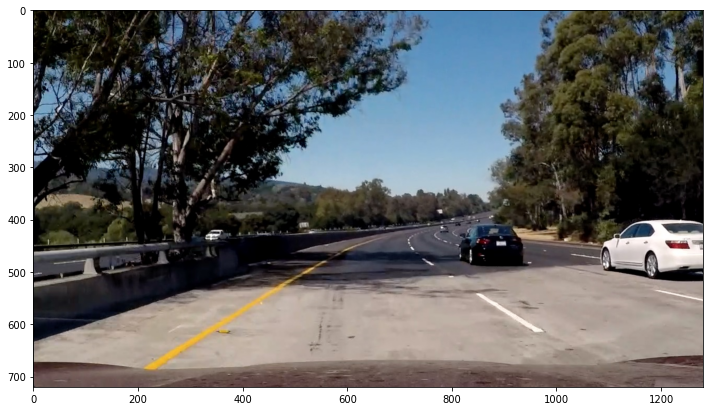

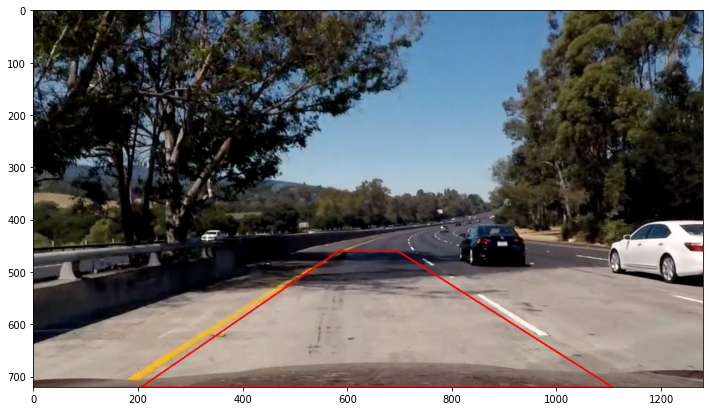

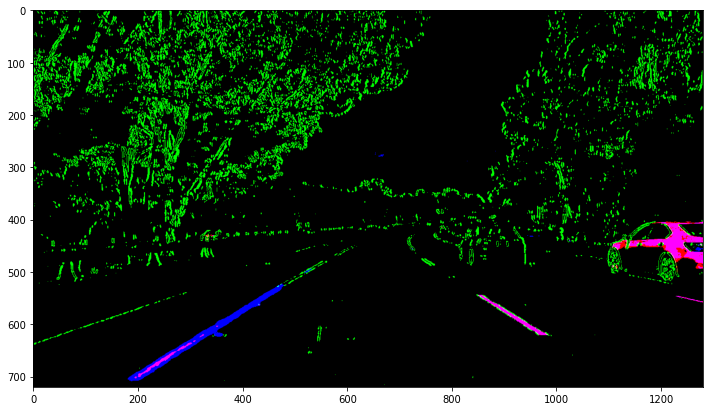

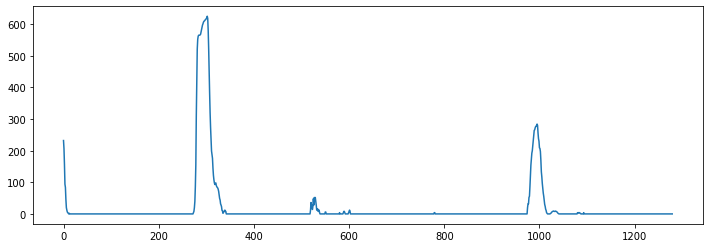

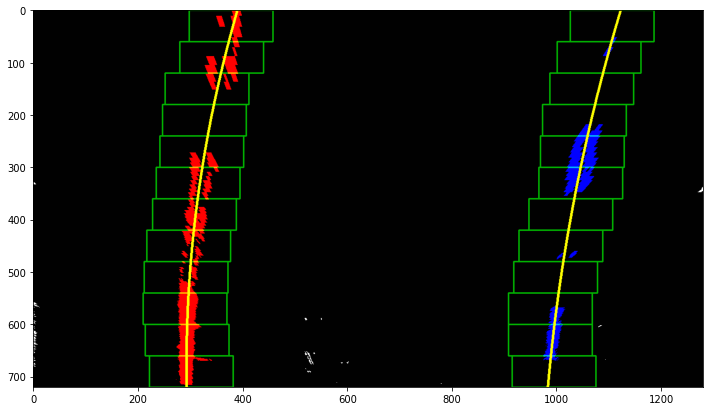

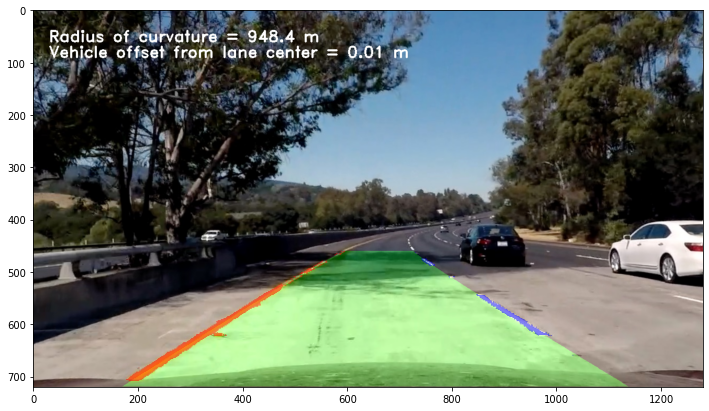

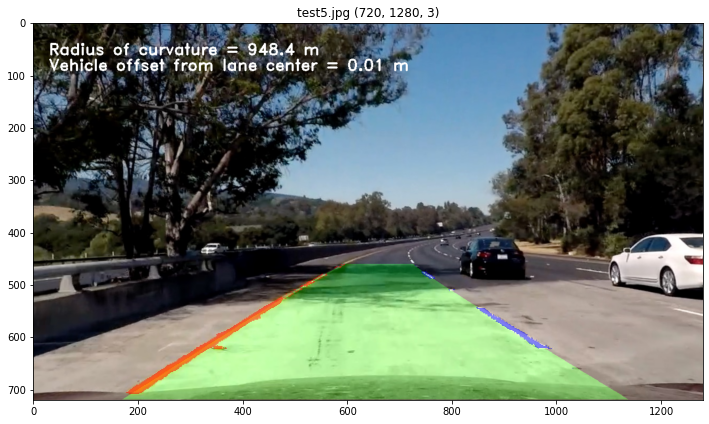

In [10]:
# Test and visualize intermedia steps with a single image

file = pl.Path('input_images/test5.jpg')

img = cv2.imread(str(file))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = pipeline(img, visualize=True)

# Plot the result in notebook
plt.figure()
plt.title("{} {}".format(file.name, img.shape))
plt.imshow(img)


## Execute on Images
Executing the pipeline on all images in 'test_images'.

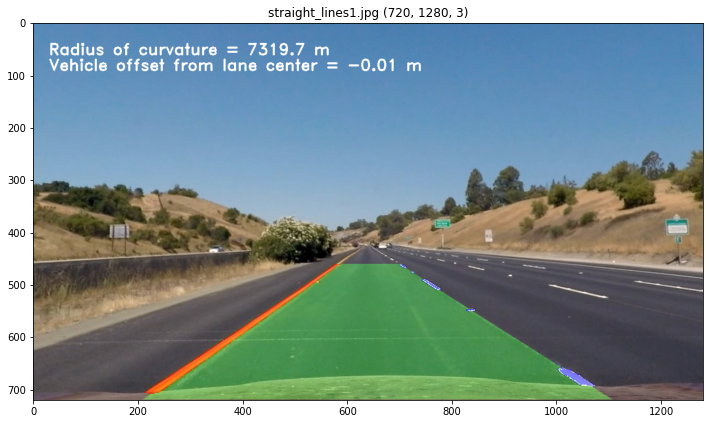

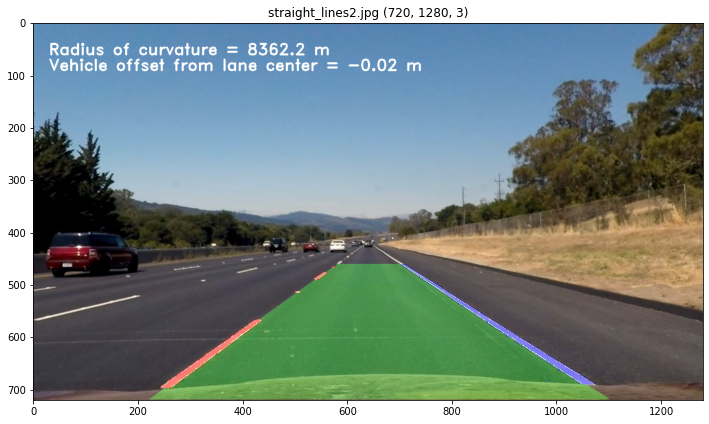

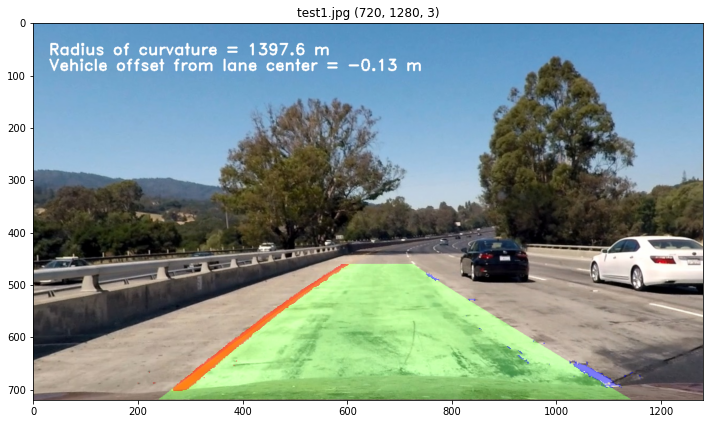

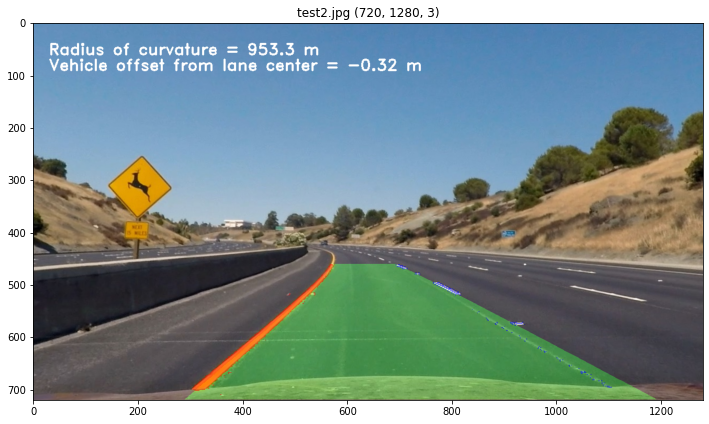

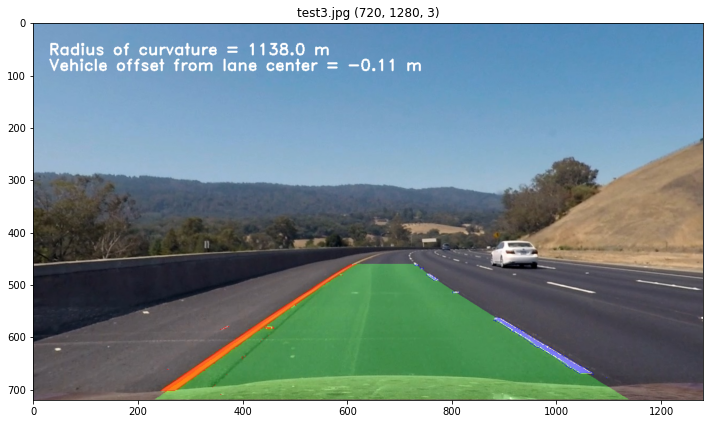

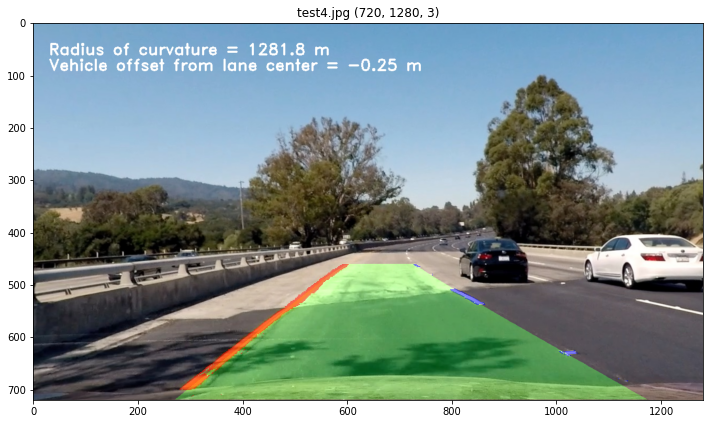

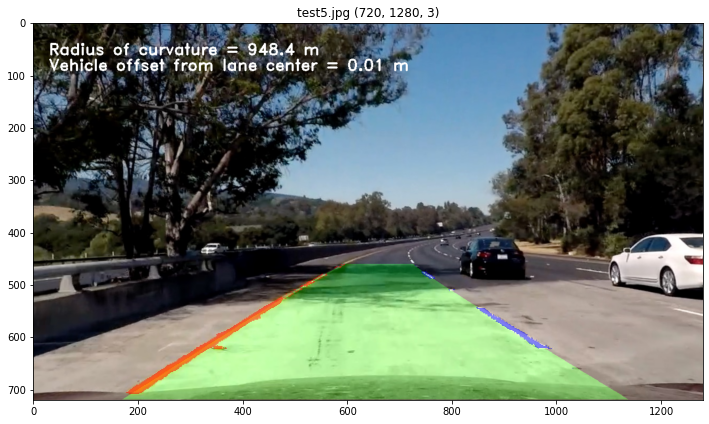

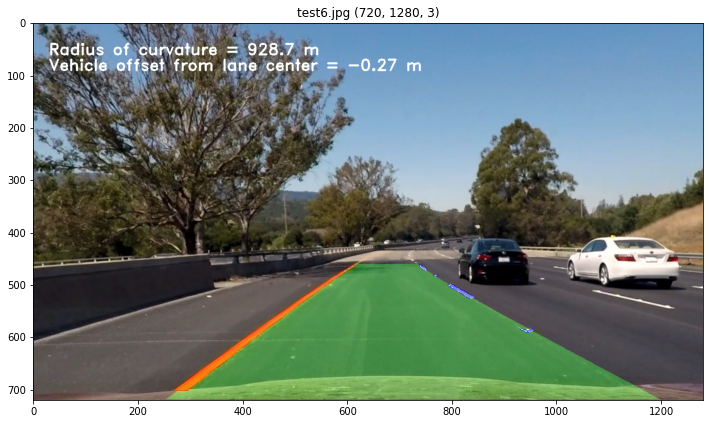

In [11]:
# apply the processing pipe line to all images in the input directory

input_dir = 'input_images'
output_dir = 'output_images'

for file in sorted(pl.Path(input_dir).iterdir()):

    # read and process
    img = cv2.imread(str(file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = pipeline(img)
    
    # plot in notebook
    plt.figure()
    plt.title("{} {}".format(file.name, img.shape))
    plt.imshow(img)
    
    # write to file
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_dir + '/' + file.name, img)

## Execute on Videos
Executing the pipeline on all videos in 'input_videos' (including the 2 more challenging examples).

In [12]:
# Apply the processing pipe line to all videos in the input directory

input_dir = 'input_videos'
output_dir = 'output_videos'

for file in sorted(pl.Path(input_dir).iterdir()):
    
    print('Parsing video "{}"'.format(file))
    clip = VideoFileClip(str(file))
#     clip = VideoFileClip(str(file)).subclip(0,5)
    
    file_output = output_dir + '/' + file.name
    clip_output = clip.fl_image(pipeline_stateful())
    
    %time clip_output.write_videofile(file_output, audio=False)    

    display(HTML("""
<div>{1}</div>
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(file_output, file_output)))
    print()

Parsing video "input_videos/01_project_video.mp4"


t:   0%|          | 2/1260 [00:00<01:27, 14.41it/s, now=None]

Moviepy - Building video output_videos/01_project_video.mp4.
Moviepy - Writing video output_videos/01_project_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/01_project_video.mp4
CPU times: user 5min 22s, sys: 34.2 s, total: 5min 56s
Wall time: 2min 31s



Parsing video "input_videos/02_challenge_video.mp4"


t:   0%|          | 2/485 [00:00<00:37, 13.04it/s, now=None]

Moviepy - Building video output_videos/02_challenge_video.mp4.
Moviepy - Writing video output_videos/02_challenge_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/02_challenge_video.mp4
CPU times: user 2min 3s, sys: 14.2 s, total: 2min 17s
Wall time: 56.7 s



Parsing video "input_videos/03_harder_challenge_video.mp4"


t:   0%|          | 0/1199 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_videos/03_harder_challenge_video.mp4.
Moviepy - Writing video output_videos/03_harder_challenge_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/03_harder_challenge_video.mp4
CPU times: user 5min 35s, sys: 34.7 s, total: 6min 10s
Wall time: 2min 56s


We are done!